In [1]:
import jax
import numpy as np
import os
import jax.numpy as jnp
from models import DimerModel
import json
from samplers.mala import MalaSamplerFull

In [2]:
working_dir = "../experiments/data/dimer"

In [3]:
with open(os.path.join(working_dir, 'dimer_params.json')) as json_file:
    dimer_params = json.load(json_file)
with open(os.path.join(working_dir, 'propsampler_params.json')) as json_file:
    cv_prop_params = json.load(json_file)
sigma_prop = cv_prop_params["sigma_prop"]
w1_proposal = cv_prop_params["w1_proposal"]
z1_prop = cv_prop_params["z1"]
z2_prop = cv_prop_params["z2"]

dimer_model = DimerModel(**dimer_params)

In [4]:
L = dimer_model.L
n = dimer_params['n']

In [5]:
sampler = MalaSamplerFull(EnergyModel=dimer_model)

x0 = np.stack(np.meshgrid(np.linspace(start=-L/2, stop = L/2, num=n, endpoint=False), np.linspace(start=-L/2, stop = L/2, num=n, endpoint=False)), axis=-1).reshape(-1,2)
x0 = np.stack([x0[:,1], x0[:,0]], axis = -1)
# x[0] = x[1] + r0/np.sqrt(2)
x0 = jnp.array(x0)

key = jax.random.key(42)
n_steps = 10000
n_chains = 1
dt = 1e-3
output_string = f"n{n_steps}nc{n_chains}_dt{dt:.4E}"
pacc_list_init, output_arr_x, output_arr_energy = sampler.get_samples_parallel(x0, dt, n_steps, n_chains, key, vectordimension=2, write_every=n_steps//2)
print(pacc_list_init.mean())

0.31


In [6]:
x_final = output_arr_x[0,-1]
dt = 5e-4
n_steps = 20000
pacc_list, output_arr_x, output_arr_energy = sampler.get_samples_parallel(x_final, dt, n_steps, n_chains, key, vectordimension=2, write_every=n_steps//2)

In [7]:
pacc_list.mean()

Array(0.67074996, dtype=float32)

In [8]:
x_final = output_arr_x[0,-1]
dimer_distance_vec = dimer_model.apply_boundaries(x_final[1] - x_final[0])
central_point = x_final[0] + 0.5 * dimer_distance_vec
x_final = x_final - central_point
x_final = dimer_model.apply_boundaries(x_final)

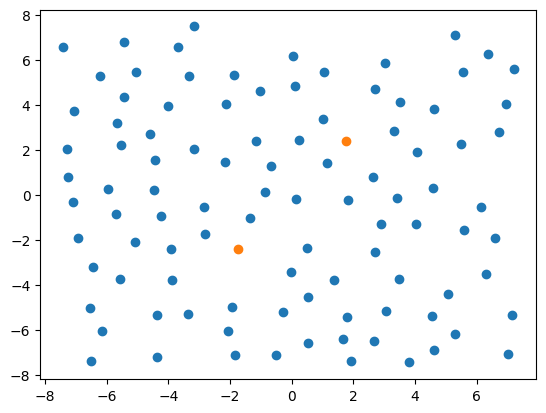

In [9]:
import matplotlib.pyplot as plt
plt.scatter(x_final[2:,0], x_final[2:,1])
plt.scatter(x_final[:2,0], x_final[:2,1])

In [10]:
# np.save('../experiments/data/dimer/x0.npy', x_final)